# Produce a mosaic of Amery for plotting
(This was written simply for downsampling the massive file provided by Julian in terms of spatial resolution and bit depth. No need to run this again, the smaller jpeg mosaics should be in the same directory.)

In [2]:
%matplotlib notebook
import rasterio as rio
from rasterio import plot
from rasterio import warp
from rasterio.enums import ColorInterp
from rasterio.windows import from_bounds
from rasterio.transform import TransformMethodsMixin
from rasterio.enums import Resampling
from rasterio.crs import CRS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from readers.read_HDF5_ATL03 import read_HDF5_ATL03
from readers.read_ICESat2_ATL06 import read_HDF5_ATL06
from readers.get_ATL03_x_atc_corrected import get_ATL03_x_atc_corrected

In [18]:
fn = 'data/L8/amery_mosaic_201901.tif'
sizes = ['large','med','small','xsmall']
for i,upscale_factor in enumerate([1,0.5,0.2,0.1]):
    size = sizes[i]
    fn_out = '%s_%s_8bit.tiff' % (fn[:-4],size)

    # bounding box in CRS (assuming antarctic polar stereographic here)
    left=1582591
    right=2015349
    bottom=627423
    top=788445

    # open and make window for reading
    dataset = rio.open(fn)
    wd = from_bounds(left, bottom, right, top, dataset.transform)

    # resample data to target shape
    data = dataset.read(window = wd,
                        out_shape=(dataset.count,int(wd.height * upscale_factor),int(wd.width * upscale_factor)),
                        resampling=Resampling.bilinear)

    # make unit8
    data = np.array(data) * 2.0 / np.iinfo(dataset.profile['dtype']).max * np.iinfo(np.uint8).max
    data[data>np.iinfo(np.uint8).max] = np.iinfo(np.uint8).max
    data = data.astype(np.uint8)

    # adjust image transform for windowing and scaling
    transform = dataset.window_transform(wd) * dataset.transform.scale((wd.width / data.shape[-1]),
                                                                       (wd.height / data.shape[-2]))

    # write out to geotiff file
    fid_out = rio.open(fn_out, 'w', 
                       driver='Gtiff',
                       width=data.shape[-1], 
                       height=data.shape[-2],
                       count=3,
                       crs=CRS.from_string('EPSG:3031'),
                       transform=transform,
                       dtype='uint8')
    fid_out.profile['photometric'] = "RGB"
    fid_out.colorinterp = [ColorInterp.red, ColorInterp.green, ColorInterp.blue]
    fid_out.write(data,[1,2,3])
    fid_out.close()
    print('wrote file', fn_out)

wrote file data/L8/amery_mosaic_201901_large_8bit.tiff
wrote file data/L8/amery_mosaic_201901_med_8bit.tiff
wrote file data/L8/amery_mosaic_201901_small_8bit.tiff
wrote file data/L8/amery_mosaic_201901_xsmall_8bit.tiff


## load one of the ICESat-2 tracks to check CRS / transform

In [19]:
data_dir = 'data/IS2/other/'
atl06file = 'ATL06_20200129235823_05230610_003_01.h5'
atl03file = 'ATL03_20200129235823_05230610_003_01.h5'
beam = 'gt3r'
IS2_atl06_mds, IS2_atl06_attrs, IS2_atl06_beams = read_HDF5_ATL06(data_dir+atl06file)
data06 = IS2_atl06_mds[beam]
IS2_atl03_mds, IS2_atl03_attrs, IS2_atl03_beams = read_HDF5_ATL03(data_dir+atl03file)
get_ATL03_x_atc_corrected(IS2_atl03_mds, IS2_atl03_attrs, IS2_atl03_beams)
data03 = IS2_atl03_mds[beam]
lat_gt = data06['land_ice_segments']['latitude']
lon_gt = data06['land_ice_segments']['longitude']
h06 = data06['land_ice_segments']['h_li']
h06[h06>1e5] = np.nan
df06 = pd.DataFrame(list(zip(lat_gt,lon_gt,h06)),columns=['lat','lon','h'])
keep = (df06.lat > -72.5) & (df06.lat < -72.2)
df06 = df06[keep].copy()

## quick plot of mosaic 

<IPython.core.display.Javascript object>


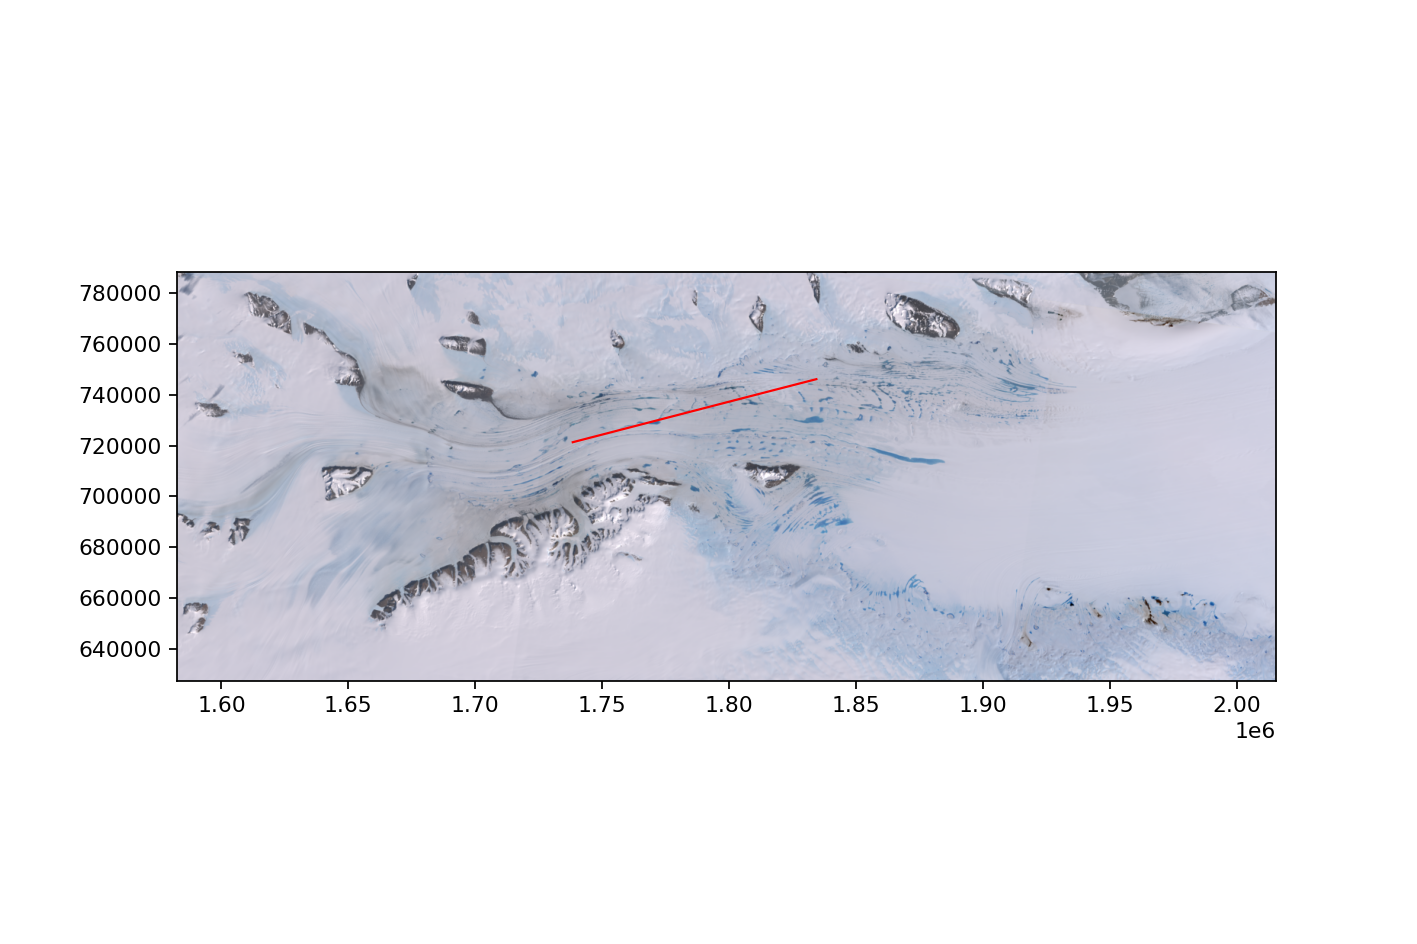

In [20]:
l8mosaic = rio.open(fn_out)
fig = plt.figure(figsize=[9,6])
ax = fig.add_subplot(111)
plot.show(l8mosaic,ax=ax)
gt_transf = warp.transform({'init': 'epsg:4326'}, l8mosaic.crs, lon_gt, lat_gt)
ax.plot(gt_transf[0], gt_transf[1], 'r-', lw=1)